#### Simulate the Positive,Negative and Random Sampling

In [143]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt


In [ ]:

def generate_grid_dataframe(grid_side_length, autocorrelation="none", n_clusters=2, random_seed=42):
    """
    Generates a GeoDataFrame based on a square grid with various spatial patterns.
    
    Parameters:
        grid_side_length (int): The number of squares along one side of the grid.
        autocorrelation (str): Type of spatial autocorrelation. Options:
                               "none" or "random" - No spatial correlation (pure random)
                               "positive" - Spatially smoothed using a Gaussian filter
                               "negative" - Spatially negative correlation (checkerboard pattern)
                               "low_cluster" - Clusters that lower the values relative to the background
                               "high_cluster" - Clusters that raise the values relative to the background
        n_clusters (int): Number of clusters to generate (only used in cluster modes).
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        GeoDataFrame: A GeoDataFrame containing square geometries and normalized values between 0 and 1.
    """
    np.random.seed(random_seed)  # Set the random seed for reproducibility

    grid_size = (grid_side_length, grid_side_length)
    
    if autocorrelation in ["none", "random"]:
        # Pure random values using uniform distribution (0 to 1)
        values = np.random.rand(*grid_size)
        
    elif autocorrelation == "positive":
        # Start with normally distributed values then smooth them
        random_values = np.random.normal(0.5, 0.125, grid_size)
        values = gaussian_filter(random_values, sigma=1.5)
        
    elif autocorrelation == "negative":
        # Create spatially negative correlation using a checkerboard sign flip
        random_values = np.random.normal(0.5, 0.125, grid_size)
        smoothed_values = gaussian_filter(random_values, sigma=1.5)
        checkerboard = np.indices(grid_size).sum(axis=0) % 2  # alternating pattern
        values = smoothed_values * (-1) ** checkerboard
        values += np.random.normal(0, 0.05, grid_size)  # add a bit of noise
        
    elif autocorrelation in ["low_cluster", "high_cluster"]:
        # Start with a random background
        values = np.random.rand(*grid_size)
        # Generate random cluster centers
        cluster_centers = np.random.randint(0, grid_side_length, (n_clusters, 2))
        cluster_radius = grid_side_length // 4  # influence radius
        
        # Apply each cluster's effect based on distance
        for center in cluster_centers:
            y, x = np.ogrid[:grid_side_length, :grid_side_length]
            # Calculate Euclidean distance from the cluster center
            dist = np.sqrt((x - center[1])**2 + (y - center[0])**2)
            # Gaussian decay of cluster effect with distance
            effect = np.exp(-dist**2 / (2 * cluster_radius**2))
            if autocorrelation == "high_cluster":
                values += effect  # add effect to raise values
            else:  # low_cluster: subtract effect to lower values
                values -= effect
        
        # Optionally, add a bit of background noise
        values += np.random.normal(0, 0.05, grid_size)
        
    else:
        raise ValueError("Invalid autocorrelation type. Choose from 'none'/'random', 'positive', 'negative', 'low_cluster', or 'high_cluster'.")

    # # Normalize values to be between 0 and 1
    # min_val = values.min()
    # max_val = values.max()
    # if max_val - min_val > 0:
    #     values = (values - min_val) / (max_val - min_val)
    # else:
    #     values = np.full(grid_size, 0.5)

    # Create a DataFrame for the grid cells
    num_squares = grid_side_length ** 2
    df = pd.DataFrame({'Index': np.arange(num_squares)})
    df['Value'] = values.ravel()

    # Function to calculate square coordinates based on the grid index
    def calculate_square_coordinates(row):
        value = row['Index']
        x = value % grid_side_length
        y = value // grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    return gdf

# Example usage:
# gdf = generate_grid_dataframe(10, autocorrelation="high_cluster", n_clusters=3, random_seed=42)
# gdf.plot(column='Value', cmap='viridis')


In [145]:
grid_length = 15
n_clusters = 4

gdf_none = generate_grid_dataframe(grid_length, autocorrelation="none", random_seed=42)        # No spatial correlation
gdf_low_clusters = generate_grid_dataframe(grid_length, autocorrelation="high_cluster",n_clusters=1, random_seed=42)  # Positive spatial correlation
gdf_high_clusters = generate_grid_dataframe(grid_length, autocorrelation="high_cluster",n_clusters=3,  random_seed=42)  # Negative spatial correlation
gdf_negative = generate_grid_dataframe(grid_length, autocorrelation="high_cluster",n_clusters=5, random_seed=42)  # Clustered spatial correlation


# print the sum of the values in each grid
print(f"Sum of values in the grid with no spatial correlation: {gdf_none['Value'].sum()}")
print(f"Sum of values in the grid with positive spatial correlation: {gdf_low_clusters['Value'].sum()}")
print(f"Sum of values in the grid with negative spatial correlation: {gdf_high_clusters['Value'].sum()}")
print(f"Sum of values in the grid with clustered spatial correlation: {gdf_negative['Value'].sum()}")



Sum of values in the grid with no spatial correlation: 107.7236199374988
Sum of values in the grid with positive spatial correlation: 135.61567795400194
Sum of values in the grid with negative spatial correlation: 224.56847699230428
Sum of values in the grid with clustered spatial correlation: 327.81147034979836


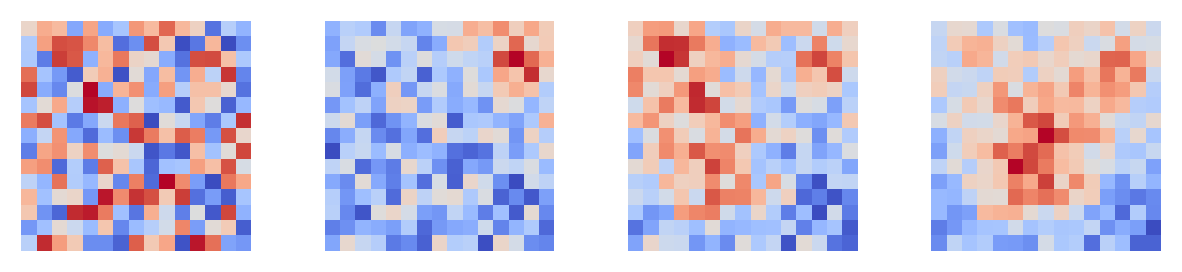

In [146]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot each GeoDataFrame and remove axes
gdf_none.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[0])
gdf_low_clusters.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[1])
gdf_high_clusters.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[2])
gdf_negative.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[3])

# Remove axes
for ax in axs:
    ax.set_axis_off()

plt.show()


In [147]:
from utills.geodata import generate_grid_dataframe,calculate_moran_i

from utills.adjacency_simplex import AdjacencySimplex 
from utills.calculate_tda_summaries import compute_persistence

In [148]:
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# create a dictionary to gdf and name
gdf_dict = {'random':gdf_none,'high clusters':gdf_high_clusters,'low clusters':gdf_low_clusters,'negative':gdf_negative}


for name,gdf in gdf_dict.items():
    gdf_temp = gdf.copy()

    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize the AdjacencySimplex class
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold = None, filter_method = 'down')

    # Filter the GeoDataFrame
    filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

    # Calculate the adjacent countries
    adj_simplex.calculate_adjacent_countries()

    # Form the simplicial complex
    simplex = adj_simplex.form_simplicial_complex()

    # Compute the persistence
    _,TL, AL, TML, AML,_ = compute_persistence(simplices=simplex,filtered_df=filtered_df,variable_name='Value')

    # Add the results to the results_df
    new_row = pd.DataFrame({'GDF': name,
                                'Filter Method': ['down'],
                                'TL': [TL],
                                'AL': [AL],
                                'TML': [TML],
                                'AML': [AML],
                                'Average': average_value},
                                )
    results_df = pd.concat([results_df,new_row],ignore_index=True)


Calculating for random
Calculating for high clusters


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_95121/1272383537.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,new_row],ignore_index=True)


Calculating for low clusters
Calculating for negative


In [149]:
results_df.head()

,GDF,Filter Method,TL,AL,TML,AML,Average
0,random,down,120.764205,0.536730,60.382102,0.268365,0.478772
1,high clusters,down,223.908081,0.995147,111.954041,0.497574,0.998082
2,low clusters,down,283.721606,1.260985,141.860803,0.630492,0.602736
3,negative,down,316.128237,1.405014,158.064118,0.702507,1.456940


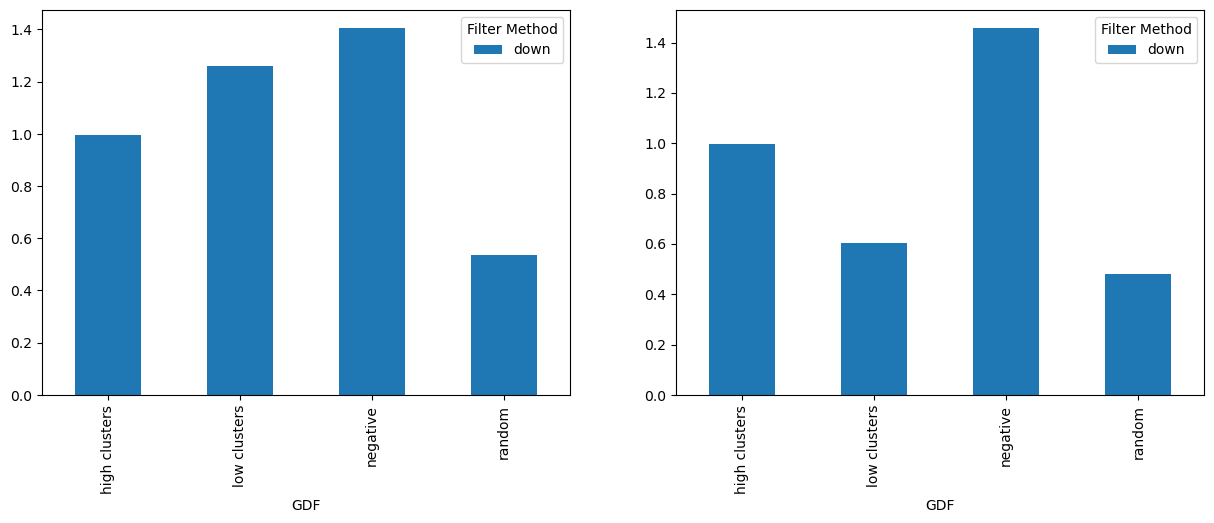

In [150]:
# plot a bar graph of the results for Al values and AML for each gdf
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the bar graph for Al values
results_df.pivot(index='GDF',columns='Filter Method',values='AL').plot(kind='bar',ax=axs[0])

# Plot the bar graph for AML values

results_df.pivot(index='GDF',columns='Filter Method',values='Average').plot(kind='bar',ax=axs[1])

plt.show()